# this is to check what generator() in `icdar.py` does! 

In [1]:
from icdar_debug import *

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import cv2

# from chainercv.visualizations import vis_bbox
# from chainercv.visualizations import vis_image
# from chainercv.utils import read_image

In [56]:
# random_scale=np.array([0.5, 1, 2.0, 3.0])
random_scale = np.array([1])

im_fn = "../data/east_char_train/shiso19340020_img_0059_1_0060_2.jpg"
im = cv2.imread(im_fn)
#print(im.shape)#(3724, 2667, 3)#it'full size at this moment
# print im_fn
h, w, _ = im.shape#so this is still a full size
txt_fn = im_fn.replace(os.path.basename(im_fn).split('.')[1], 'txt')

text_polys, text_tags = load_annoataion(txt_fn)

text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
# if text_polys.shape[0] == 0:
#     continue

###
#here is the first point to resize image
###
# random scale this image
rd_scale = np.random.choice(random_scale)
print("rd_scale",rd_scale)

im_ori = cv2.resize(im, dsize=None, fx=rd_scale, fy=rd_scale)
text_polys *= rd_scale
# print rd_scale
# random crop a area from image

rd_scale 1


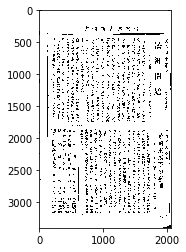

In [44]:
plt.imshow(im_ori)

# crop background case

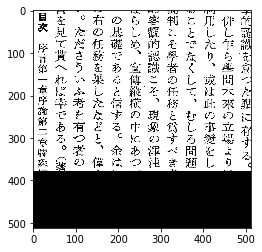

In [39]:
im = im_ori
# crop background
input_size = 512
im, text_polys, text_tags = crop_area(im, text_polys, text_tags, crop_background=True)
# pad and resize image
new_h, new_w, _ = im.shape
max_h_w_i = np.max([new_h, new_w, input_size])
im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
im_padded[:new_h, :new_w, :] = im.copy()
im = cv2.resize(im_padded, dsize=(input_size, input_size))
score_map = np.zeros((input_size, input_size), dtype=np.uint8)
geo_map_channels = 5 
geo_map = np.zeros((input_size, input_size, geo_map_channels), dtype=np.float32)
training_mask = np.ones((input_size, input_size), dtype=np.uint8)

plt.imshow(im)

# the other case

In [ ]:
2048x1024672

In [48]:
im_ori.shape

(3409, 2057, 3)

In [57]:
im = im_ori

h, w, _ = im.shape
# resize the image to input size
new_h, new_w, _ = im.shape
resize_h = 2016
resize_w = 1344
im = cv2.resize(im, dsize=(resize_w, resize_h))
resize_ratio_3_x = resize_w/float(new_w)
resize_ratio_3_y = resize_h/float(new_h)
text_polys[:, :, 0] *= resize_ratio_3_x
text_polys[:, :, 1] *= resize_ratio_3_y
new_h, new_w, _ = im.shape
score_map, geo_map, training_mask = generate_rbox((new_h, new_w), text_polys, text_tags)

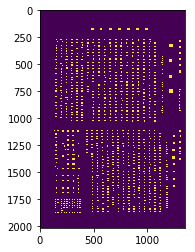

In [58]:
plt.imshow(score_map)

In [ ]:
def generator_fullsize(input_size=512, batch_size=32,
              background_ratio=3./8,
              random_scale=np.array([0.5, 1, 2.0, 3.0]),
              vis=False):
    image_list = np.array(get_images())
    print('{} training images in {}'.format(
        image_list.shape[0], FLAGS.training_data_path))
    index = np.arange(0, image_list.shape[0])
    while True:
        np.random.shuffle(index)
        images = []
        image_fns = []
        score_maps = []
        geo_maps = []
        training_masks = []
        for i in index:
            try:
                im_fn = image_list[i]
                im = cv2.imread(im_fn)
                #print(im.shape)#(3724, 2667, 3)#it'full size at this moment
                # print im_fn
                h, w, _ = im.shape#so this is still a full size
                txt_fn = im_fn.replace(os.path.basename(im_fn).split('.')[1], 'txt')
                if not os.path.exists(txt_fn):
                    print('text file {} does not exists'.format(txt_fn))
                    continue

                text_polys, text_tags = load_annoataion(txt_fn)

                text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
                if text_polys.shape[0] == 0:
                    continue
                    
                # resize the image to input size
                new_h, new_w, _ = im.shape
                resize_h = 2016
                resize_w = 1344
                im = cv2.resize(im, dsize=(resize_w, resize_h))
                resize_ratio_3_x = resize_w/float(new_w)
                resize_ratio_3_y = resize_h/float(new_h)
                text_polys[:, :, 0] *= resize_ratio_3_x
                text_polys[:, :, 1] *= resize_ratio_3_y
                new_h, new_w, _ = im.shape
                score_map, geo_map, training_mask = generate_rbox((new_h, new_w), text_polys, text_tags)


                images.append(im[:, :, ::-1].astype(np.float32))
                image_fns.append(im_fn)
                score_maps.append(score_map[::4, ::4, np.newaxis].astype(np.float32))
                geo_maps.append(geo_map[::4, ::4, :].astype(np.float32))
                training_masks.append(training_mask[::4, ::4, np.newaxis].astype(np.float32))

                if len(images) == batch_size:
                    yield images, image_fns, score_maps, geo_maps, training_masks
                    images = []
                    image_fns = []
                    score_maps = []
                    geo_maps = []
                    training_masks = []
            except Exception as e:
                import traceback
                traceback.print_exc()
                continue